## LTC Model deployment

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from keras.models import load_model

from api_keys import coinapi_key

2023-09-17 19:02:39.313763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:02:09.8730000Z', 'time_close': '2023-01-02T23:55:47.2360000Z', 'price_open': 71.01, 'price_high': 77.01, 'price_low': 70.09, 'price_close': 74.75, 'volume_traded': 12597.08873021, 'trades_count': 1357}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:02:07.6980000Z', 'time_close': '2023-01-03T23:55:34.7550000Z', 'price_open': 74.59, 'price_high': 76.38, 'price_low': 73.76, 'price_close': 75.6, 'volume_traded': 7900.38087519, 'trades_count': 899}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:01:13.2740000Z', 'time_close': '2023-01-04T23:55:12.4840000Z', 'price_open': 75.44, 'price_high': 77.89, 'price_low': 74.41, 'price_close': 75.51, 'volume_traded': 11627.82451562, 'trades_count': 1

In [4]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:02:09.8730000Z,2023-01-02T23:55:47.2360000Z,71.01,77.01,70.09,74.75,12597.088730,1357
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:02:07.6980000Z,2023-01-03T23:55:34.7550000Z,74.59,76.38,73.76,75.60,7900.380875,899
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:01:13.2740000Z,2023-01-04T23:55:12.4840000Z,75.44,77.89,74.41,75.51,11627.824516,1374
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:02:16.9880000Z,2023-01-05T23:56:30.5730000Z,75.60,76.16,73.65,74.01,7860.937082,790
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:03:20.2010000Z,2023-01-06T23:59:41.9260000Z,73.95,76.53,72.66,75.93,13966.363517,1259


In [5]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,74.75
2023-01-03,75.60
2023-01-04,75.51
2023-01-05,74.01
2023-01-06,75.93
...,...
2023-09-13,61.99
2023-09-14,62.86
2023-09-15,65.99


In [6]:
close = data['Close']

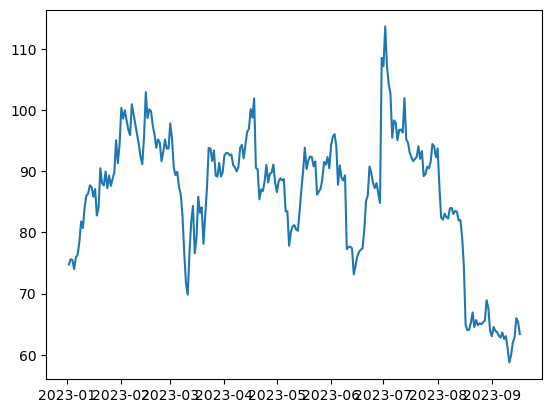

In [7]:
#plot historical eth price
plt.plot(close)

In [8]:
# build 7 day lookback for lstm training (includes first column since we are not splitting off the first row)
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2023-01-08,78.46,76.35,75.93,74.01,75.51,75.60,74.75
2023-01-09,81.80,78.46,76.35,75.93,74.01,75.51,75.60
2023-01-10,80.70,81.80,78.46,76.35,75.93,74.01,75.51
2023-01-11,84.07,80.70,81.80,78.46,76.35,75.93,74.01
2023-01-12,86.01,84.07,80.70,81.80,78.46,76.35,75.93
...,...,...,...,...,...,...,...
2023-09-13,61.99,59.93,58.75,61.13,63.05,62.60,63.66
2023-09-14,62.86,61.99,59.93,58.75,61.13,63.05,62.60
2023-09-15,65.99,62.86,61.99,59.93,58.75,61.13,63.05


In [9]:
#create array of dates for plotting from new index. 
dates = shifted_df.index

dates.shape

(249,)

In [10]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np


shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(249, 7)

In [22]:
#Load Trained Model
model = load_model("H5_Files/ltc_7_day_3.h5")

In [23]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 23ms/step
[4.060977, 4.047737, 4.037084, 4.0293837, 4.021992, 4.0156364, 4.008929]
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24


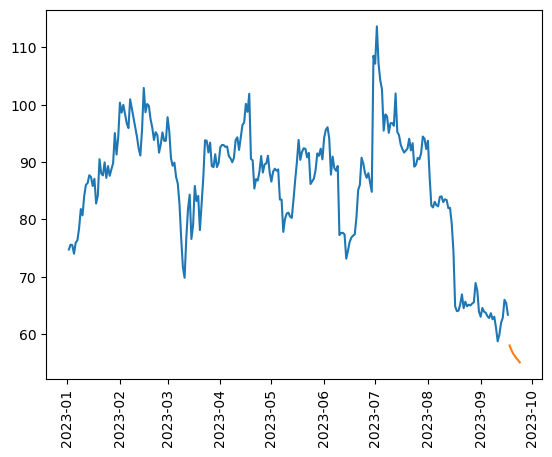

In [24]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [25]:
#load trained model 2
model2 = load_model("H5_Files/ltc_7_day_1.h5")
#load trained model 3
model3 = load_model("H5_Files/ltc_7_day_2.h5")

In [26]:
#build predictions for second 2 models

# Initialize an array to store predictions
predictions2 = []
prediction_range2 = 7


# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range2):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model2.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions2.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    
# Initialize an array to store predictions
predictions3 = []
prediction_range3 = 7


# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range3):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions3.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred


    

1/1 [==============================] - 0s 24ms/step


In [27]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions),\
                    "future_prediction2": np.exp(predictions2), "future_prediction3": np.exp(predictions3)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-01-08,78.46,NaN,NaN,NaN
2023-01-09,81.80,NaN,NaN,NaN
2023-01-10,80.70,NaN,NaN,NaN
2023-01-11,84.07,NaN,NaN,NaN
2023-01-12,86.01,NaN,NaN,NaN


In [28]:
past_future_df.tail()



,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-09-20,NaN,56.660885,52.032242,61.112194
2023-09-21,NaN,56.226246,50.166454,61.794483
2023-09-22,NaN,55.812180,48.349922,62.559757
2023-09-23,NaN,55.458580,46.586918,63.415829
2023-09-24,NaN,55.087830,44.879242,64.205315


In [38]:
pred_columns = past_future_df[['future_prediction','future_prediction2','future_prediction3' ]]

pred_means = pred_columns.mean(axis=1)

past_future_df['mean'] = pred_means

past_future_df

,observed,future_prediction,future_prediction2,future_prediction3,mean
Date,,,,,
2023-01-08,78.46,NaN,NaN,NaN,NaN
2023-01-09,81.80,NaN,NaN,NaN,NaN
2023-01-10,80.70,NaN,NaN,NaN,NaN
2023-01-11,84.07,NaN,NaN,NaN,NaN
2023-01-12,86.01,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-09-20,NaN,56.660885,52.032242,61.112194,56.601776
2023-09-21,NaN,56.226246,50.166454,61.794483,56.062393
2023-09-22,NaN,55.812180,48.349922,62.559757,55.573956


In [39]:
past_future_df.to_csv('output/ltc_model.csv') 